In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
from six import StringIO
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix
from category_encoders import BinaryEncoder
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
color = sns.color_palette()
seed = 42

In [46]:
data = pd.read_csv('lending_club_loan_dataset.csv',low_memory=False)
data.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [47]:
data.describe().round(3)

,id,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,2.000000e+04,20000.000,20000.000,20000.000,19846.000,20000.000,574.000,20000.000,20000.000,20000.000,20000.0
mean,7.590662e+06,73349.578,0.112,6.821,16.588,0.547,0.760,55.958,0.291,0.504,0.2
std,1.609593e+06,45198.567,0.316,3.774,7.586,0.498,0.428,42.117,3.109,0.288,0.4
min,5.860400e+05,8412.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
25%,6.206283e+06,47000.000,0.000,3.000,10.852,0.000,1.000,38.800,0.000,0.257,0.0
50%,7.378896e+06,65000.000,0.000,7.000,16.190,1.000,1.000,57.100,0.000,0.507,0.0
75%,8.766235e+06,88000.000,0.000,11.000,22.060,1.000,1.000,73.900,0.000,0.754,0.0
max,1.145464e+07,1000000.000,1.000,11.000,34.990,1.000,1.000,5010.000,96.467,1.000,1.0


In [48]:
data.describe(include=[np.object])

<ipython-input-48-c07674af406a>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.describe(include=[np.object])


,grade,home_ownership,purpose,term
count,20000,18509,20000,20000
unique,7,3,12,3
top,B,MORTGAGE,debt_consolidation,36 months
freq,6042,9844,12337,14969


In [49]:
loan = data.bad_loan.value_counts().to_frame().rename(columns={"bad_loan":"absolute"})
loan["percent"] = (loan.apply(lambda x: x/x.sum()*100).round(2))
display(loan)

,absolute,percent
0,16000,80.0
1,4000,20.0


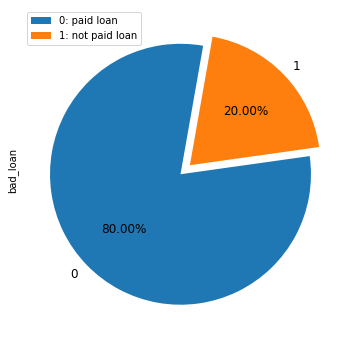

In [50]:
data.bad_loan.value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%', explode= (0.05, 0.05), startangle=80, legend=True, fontsize=12, figsize=(14,6), textprops={'color':"black"})
plt.legend(["0: paid loan","1: not paid loan"]);

In [51]:
data.dtypes.sort_values(ascending=True)

id                         int64
short_emp                  int64
emp_length_num             int64
last_delinq_none           int64
bad_loan                   int64
annual_inc               float64
dti                      float64
last_major_derog_none    float64
revol_util               float64
total_rec_late_fee       float64
od_ratio                 float64
grade                     object
home_ownership            object
purpose                   object
term                      object
dtype: object

In [52]:
data.dtypes.value_counts()

float64    6
int64      5
object     4
dtype: int64

In [53]:
nulval = data.isnull().sum().to_frame().rename(columns={0:"absolute"})
nulval["percent"] = (nulval.apply(lambda x: x/x.sum())*100).round(2)
nulval

,absolute,percent
id,0,0.00
grade,0,0.00
annual_inc,0,0.00
short_emp,0,0.00
emp_length_num,0,0.00
home_ownership,1491,7.08
dti,154,0.73
purpose,0,0.00
term,0,0.00
last_delinq_none,0,0.00


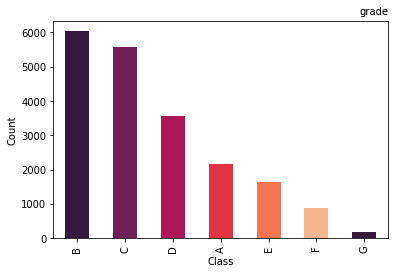

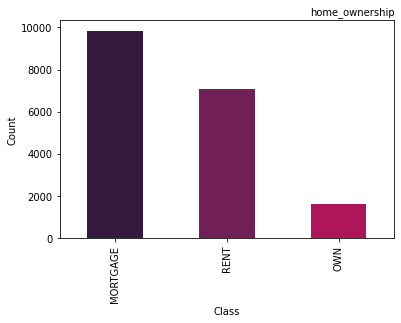

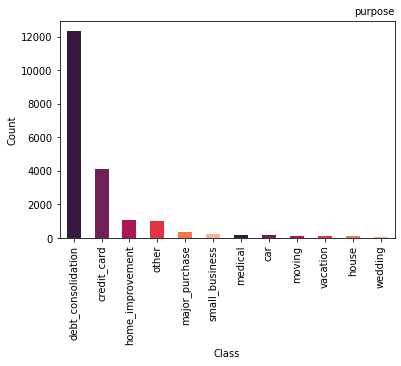

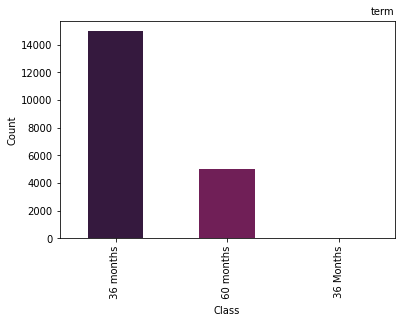

In [54]:
for col in data.select_dtypes(include=["object"]).columns:
    data[col].value_counts().plot(kind="bar", color=sns.color_palette("rocket"))
    
    plt.xlabel("Class", fontsize=10)
    plt.xticks(rotation=90, horizontalalignment="center")
    plt.ylabel("Count", fontsize=10)
    plt.title(col, fontsize=10, loc="right")
    plt.show()

In [55]:
data.term = data.term.str.lower()
data.term.value_counts()

 36 months    15001
 60 months     4999
Name: term, dtype: int64

In [56]:
data_spear = data.copy()
data_spear.drop(["bad_loan"], axis=1, inplace=True)
spearman_rank = pg.pairwise_corr(data_spear, method='spearman').loc[:,['X','Y','r']]
pos = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[:5,:]
neg = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[-5:,:]
con = pd.concat([pos,neg], axis=0)
display(con.reset_index(drop=True))

,X,Y,r
0,last_delinq_none,last_major_derog_none,0.603267
1,annual_inc,emp_length_num,0.178792
2,dti,revol_util,0.176115
3,short_emp,last_major_derog_none,0.072290
4,annual_inc,revol_util,0.062358
5,annual_inc,last_delinq_none,-0.101568
6,annual_inc,short_emp,-0.137179
7,emp_length_num,last_major_derog_none,-0.160225
8,annual_inc,dti,-0.223426
9,short_emp,emp_length_num,-0.557925


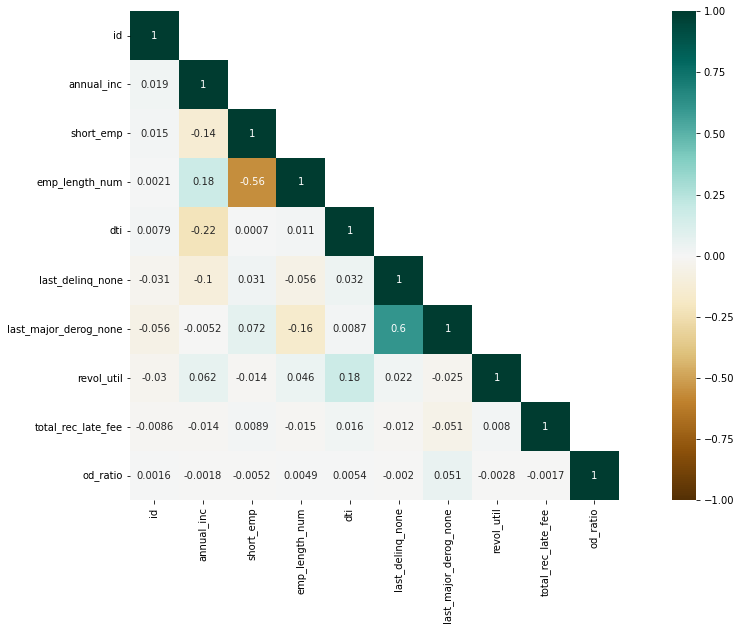

In [57]:
mask = np.triu(data_spear.corr(method='spearman'), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(data_spear.corr(method='spearman'), annot=True, vmax=1, vmin=-1, square=True, cmap='BrBG', mask=mask);

In [58]:
data_ca = data.select_dtypes(exclude=["int64","float64"]).copy()
data_nu = data.select_dtypes(exclude=["object","category"]).copy()

C:\Python39\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
C:\Python39\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
C:\Python39\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
C:\Python39\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
C:\Python39\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
C:\Python39\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal ori

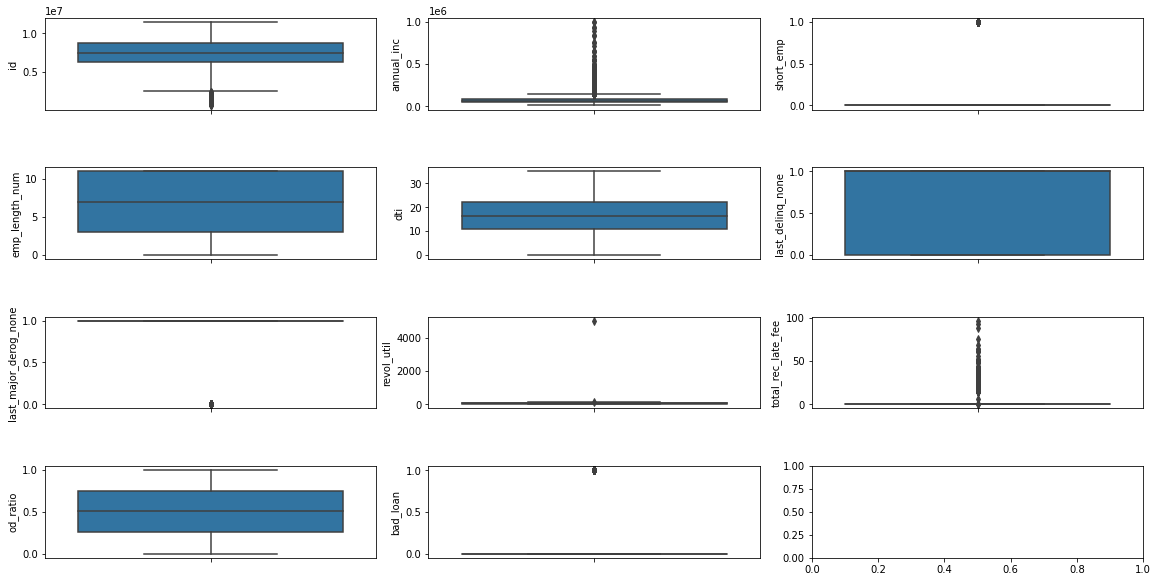

In [59]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(16, 8))
index = 0
axs = axs.flatten()
for k,v in data_nu.items():
    sns.boxplot(y=k, data=data_nu, ax=axs[index], orient="h")
    index += 1
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [60]:
display(data.describe().loc[["mean","50%","std"]].loc[:,["annual_inc","revol_util","total_rec_late_fee"]])

,annual_inc,revol_util,total_rec_late_fee
mean,73349.578350,55.958148,0.290622
50%,65000.000000,57.100000,0.000000
std,45198.567255,42.117456,3.108654


In [61]:
print(data.annual_inc.describe())

count      20000.000000
mean       73349.578350
std        45198.567255
min         8412.000000
25%        47000.000000
50%        65000.000000
75%        88000.000000
max      1000000.000000
Name: annual_inc, dtype: float64


In [62]:
Q1 = data['annual_inc'].quantile(0.25)
Q3 = data['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
data['annual_inc'] = data.annual_inc[~((data.annual_inc < (Q1 - 1.5 * IQR)) |(data.annual_inc > (Q3 + 1.5 * IQR)))]
print(data.annual_inc.describe())

count     19074.000000
mean      66792.117857
std       27241.646991
min        8412.000000
25%       46000.000000
50%       62000.000000
75%       84000.000000
max      149000.000000
Name: annual_inc, dtype: float64


In [63]:
print(int(data_nu.annual_inc.describe()[0]) - int(data.annual_inc.describe()[0]),"outliers were removed with this operation.")

926 outliers were removed with this operation.


In [64]:
print(data.revol_util.describe())

count    20000.000000
mean        55.958148
std         42.117456
min          0.000000
25%         38.800000
50%         57.100000
75%         73.900000
max       5010.000000
Name: revol_util, dtype: float64


In [65]:
value = data.revol_util.quantile([.99999])
p = value.iloc[0]
data = data[data["revol_util"] < p]

In [66]:
print(data['revol_util'].describe())

count    19999.000000
mean        55.710434
std         23.380722
min          0.000000
25%         38.800000
50%         57.100000
75%         73.900000
max        128.100000
Name: revol_util, dtype: float64


In [67]:
print(int(data_nu.revol_util.describe()[0]) - int(data.revol_util.describe()[0]),"outlier was removed with this operation.")

1 outlier was removed with this operation.


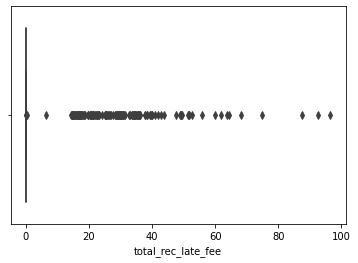

In [68]:
sns.boxplot(x=data['total_rec_late_fee'],data=data)
plt.xlabel('total_rec_late_fee', fontsize=10)
plt.show()

In [69]:
value = data.total_rec_late_fee.quantile([.989])
p = value.iloc[0]
data = data[data["total_rec_late_fee"] < p]

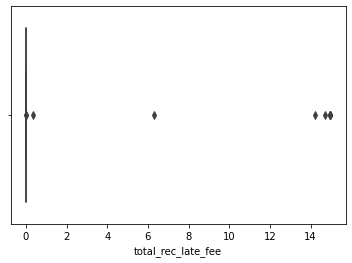

In [70]:
sns.boxplot(x=data['total_rec_late_fee'],data=data)
plt.xlabel('total_rec_late_fee', fontsize=10)
plt.show()

In [71]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ---> '{portion:.3f}%'")

'annual_inc': number of missing values '915' ---> '4.626%'
'home_ownership': number of missing values '1476' ---> '7.462%'
'dti': number of missing values '152' ---> '0.768%'
'last_major_derog_none': number of missing values '19208' ---> '97.113%'


In [72]:
data.annual_inc.value_counts(dropna=False)

NaN         915
60000.0     771
50000.0     729
65000.0     607
70000.0     599
           ... 
49955.0       1
112711.0      1
66389.0       1
62212.0       1
36676.0       1
Name: annual_inc, Length: 2349, dtype: int64

In [73]:
data["annual_inc"] = data.annual_inc.fillna(data.annual_inc.mean())
print(f"Fillna done. Anomalies detected: {data.annual_inc.isnull().values.any()}")

Fillna done. Anomalies detected: False


In [74]:
data.home_ownership.value_counts(dropna=False)

MORTGAGE    9744
RENT        6959
OWN         1600
NaN         1476
Name: home_ownership, dtype: int64

In [75]:
data["home_ownership"] = data.home_ownership.fillna(data.home_ownership.value_counts().index[0])
print(f"Imputation done. Missing values: {data.home_ownership.isnull().sum()}")

Imputation done. Missing values: 0


In [76]:
data.dti.value_counts(dropna=False)

NaN      152
15.87     20
19.64     20
19.25     19
11.45     19
        ... 
34.32      1
0.11       1
1.61       1
1.47       1
32.53      1
Name: dti, Length: 3286, dtype: int64

In [77]:
data["dti"] = data.dti.fillna(data.dti.mean())
print(f"Fillna done. Missing values: {data.dti.isnull().values.any()}")

Fillna done. Missing values: False


In [78]:
abs_mv = data.last_major_derog_none.value_counts(dropna=False)
pc_mv = data.last_major_derog_none.value_counts(dropna=False, normalize=True) * 100
pc_mv_df = pd.DataFrame(pc_mv)
pc_mv_df.rename(columns={"last_major_derog_none":"Percent %"}, inplace=True)
abs_pc = pd.concat([abs_mv,pc_mv_df], axis=1)
abs_pc

,last_major_derog_none,Percent %
NaN,19208,97.113100
1.0,435,2.199302
0.0,136,0.687598


In [79]:
data.drop("last_major_derog_none", axis=1, inplace=True)
print(f"All missing values are solved in the entire dataset: {data.notnull().values.any()}")

All missing values are solved in the entire dataset: True


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19779 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  19779 non-null  int64  
 1   grade               19779 non-null  object 
 2   annual_inc          19779 non-null  float64
 3   short_emp           19779 non-null  int64  
 4   emp_length_num      19779 non-null  int64  
 5   home_ownership      19779 non-null  object 
 6   dti                 19779 non-null  float64
 7   purpose             19779 non-null  object 
 8   term                19779 non-null  object 
 9   last_delinq_none    19779 non-null  int64  
 10  revol_util          19779 non-null  float64
 11  total_rec_late_fee  19779 non-null  float64
 12  od_ratio            19779 non-null  float64
 13  bad_loan            19779 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 2.3+ MB


In [81]:
data.drop("id", axis=1, inplace=True)

In [82]:
data.shape

(19779, 13)

In [83]:
 data_nu = data.select_dtypes(exclude=["object","category"]).copy()

In [84]:
Xnum = data_nu.drop(["bad_loan"], axis= "columns")
ynum = data_nu.bad_loan

In [85]:
pd.DataFrame(
    [scipy.stats.pearsonr(Xnum[col], 
    ynum) for col in Xnum.columns], 
    columns=["Pearson Corr.", "p-value"], 
    index=Xnum.columns,
).round(4)

,Pearson Corr.,p-value
annual_inc,-0.1227,0.0000
short_emp,0.0368,0.0000
emp_length_num,-0.0406,0.0000
dti,0.1394,0.0000
last_delinq_none,0.0216,0.0024
revol_util,0.1013,0.0000
total_rec_late_fee,0.0240,0.0007
od_ratio,0.0007,0.9214


In [86]:
Xcat = data.select_dtypes(exclude=['int64','float64']).copy()

In [87]:
Xcat['target'] = data.bad_loan
Xcat.dropna(how="any", inplace=True)
ycat = Xcat.target
Xcat.drop("target", axis=1, inplace=True)

In [88]:
for col in Xcat.columns:
    table = pd.crosstab(Xcat[col], ycat)
    print()
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.25f}")

target,0,1
grade,,
A,2030,120
B,5257,736
C,4375,1127
D,2566,947
E,1099,516
F,509,333
G,102,62


p-value: 0.0000000000000000000000000



target,0,1
home_ownership,,
MORTGAGE,9298,1922
OWN,1293,307
RENT,5347,1612


p-value: 0.0000000000000000000001931



target,0,1
purpose,,
car,138,30
credit_card,3424,679
debt_consolidation,9824,2386
home_improvement,881,199
house,85,12
major_purchase,289,83
medical,135,37
moving,92,28
other,745,261


p-value: 0.0000000000000872350281927



target,0,1
term,,
36 months,12416,2437
60 months,3522,1404


p-value: 0.0000000000000000000000000


In [89]:
data["grade"] = data.grade.map({"A":7, "B":6, "C":5, "D":4, "E":3, "F":2, "G":1})

In [90]:
df_term = data.term
df_home = data.home_ownership
df_purp = data.purpose
#term
t_ohe = pd.get_dummies(df_term)
bin_enc_term = BinaryEncoder()
t_bin = bin_enc_term.fit_transform(df_term)
#home_ownsership
h_ohe = pd.get_dummies(df_home)
bin_enc_home = BinaryEncoder()
h_bin = bin_enc_home.fit_transform(df_home)
#purpose
p_ohe = pd.get_dummies(df_purp)
bin_enc_purp = BinaryEncoder()
p_bin = bin_enc_purp.fit_transform(df_purp)

In [91]:
data = pd.get_dummies(data, columns=["term","home_ownership"])

In [92]:
bin_enc_purp = BinaryEncoder()
data_bin = bin_enc_purp.fit_transform(data.purpose)

In [93]:
# Concatenating both datasets
df = pd.concat([data,data_bin],axis=1)
# Dropping 'purpose'
df.drop(["purpose"], axis=1, inplace=True)
# Lowering upper characters
df.columns = [x.lower() for x in df.columns]
# printing 5 first rows
df.head()

,grade,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan,term_ 36 months,term_ 60 months,home_ownership_mortgage,home_ownership_own,home_ownership_rent,purpose_0,purpose_1,purpose_2,purpose_3
0,7,100000.0,1,1,26.27,1,43.2,0.0,0.160624,0,1,0,0,0,1,0,0,0,1
1,7,83000.0,0,4,5.39,0,21.5,0.0,0.810777,0,1,0,0,1,0,0,0,0,1
2,4,78000.0,0,11,18.45,1,46.3,0.0,0.035147,1,0,1,1,0,0,0,0,1,0
3,4,37536.0,0,6,12.28,0,10.7,0.0,0.534887,1,0,1,1,0,0,0,0,1,1
4,4,65000.0,0,11,11.26,0,15.2,0.0,0.166500,0,1,0,1,0,0,0,0,1,0


In [94]:
# Making a copy of the dataset
df_lr = df.copy()

# Dividing the dataset in train (80%) and test (20%)
train_set_lr, test_set_lr = train_test_split(df_lr, test_size = 0.2, random_state = seed)
X_train_lr = train_set_lr.drop(['bad_loan'], axis = 1)
y_train_lr = train_set_lr['bad_loan']
X_test_lr = test_set_lr.drop(['bad_loan'], axis = 1)
y_test_lr = test_set_lr['bad_loan']

# Normalizing the train and test data
scaler_lr = MinMaxScaler()
features_names = X_train_lr.columns
X_train_lr = scaler_lr.fit_transform(X_train_lr)
X_train_lr = pd.DataFrame(X_train_lr, columns = features_names)
X_test_lr = scaler_lr.transform(X_test_lr)
X_test_lr = pd.DataFrame(X_test_lr, columns = features_names)

In [95]:
lr = LogisticRegression(max_iter = 1000, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train_lr, y_train_lr)

In [96]:
clf_lr

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [97]:
clf_lr.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [98]:
y_preds_lr = clf_lr.predict_proba(X_test_lr)[:,1]

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


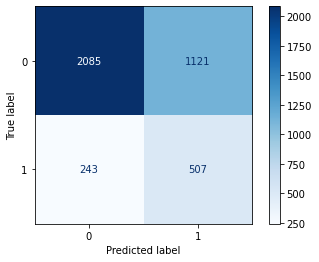

In [99]:
# Confusion Matrix display
plot_confusion_matrix(clf_lr, X_test_lr, y_test_lr, values_format=".4g", cmap="Blues");
# Creating assignments for Final Results
tn, fp, fn, tp = confusion_matrix(y_test_lr == 1, y_preds_lr > 0.5).ravel()
tn_lr = tn
fp_lr = fp
fn_lr = fn
tp_lr = tp

In [100]:
# Making a copy of the dataset
df_knn = df.copy()

# Dividing the dataset in train (80%) and test (20%)
train_set_knn, test_set_knn = train_test_split(df_knn, test_size = 0.2, random_state = seed)
X_train_knn = train_set_knn.drop(['bad_loan'], axis = 1)
y_train_knn = train_set_knn['bad_loan']
X_test_knn = test_set_knn.drop(['bad_loan'], axis = 1)
y_test_knn = test_set_knn['bad_loan']

# Normalizing train and test data
scaler_knn = MinMaxScaler()
features_names = X_train_knn.columns
X_train_knn = scaler_knn.fit_transform(X_train_knn)
X_train_knn = pd.DataFrame(X_train_knn, columns = features_names)
X_test_knn = scaler_knn.transform(X_test_knn)
X_test_knn = pd.DataFrame(X_test_knn, columns = features_names)


for k in range(1, 200, 5):
    k = k + 1
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train_knn, y_train_knn)
    acc = knn.score(X_test_knn, y_test_knn)
    print('Accuracy for k =', k, ' is:', acc)

Accuracy for k = 2  is: 0.7904448938321537
Accuracy for k = 7  is: 0.7939838220424671
Accuracy for k = 12  is: 0.8066228513650152
Accuracy for k = 17  is: 0.8063700707785642
Accuracy for k = 22  is: 0.8086450960566228
Accuracy for k = 27  is: 0.8081395348837209
Accuracy for k = 32  is: 0.8099089989888777
Accuracy for k = 37  is: 0.8109201213346815
Accuracy for k = 42  is: 0.8111729019211324
Accuracy for k = 47  is: 0.8109201213346815
Accuracy for k = 52  is: 0.8094034378159757
Accuracy for k = 57  is: 0.8104145601617796
Accuracy for k = 62  is: 0.8101617795753286
Accuracy for k = 67  is: 0.8104145601617796
Accuracy for k = 72  is: 0.8101617795753286
Accuracy for k = 77  is: 0.8101617795753286
Accuracy for k = 82  is: 0.8104145601617796
Accuracy for k = 87  is: 0.8104145601617796
Accuracy for k = 92  is: 0.8101617795753286
Accuracy for k = 97  is: 0.8099089989888777
Accuracy for k = 102  is: 0.8101617795753286
Accuracy for k = 107  is: 0.8104145601617796
Accuracy for k = 112  is: 0.8101

In [101]:
knn = KNeighborsClassifier(n_neighbors = 47, weights='uniform').fit(X_train_knn, y_train_knn)
y_preds_knn = knn.predict(X_test_knn)

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


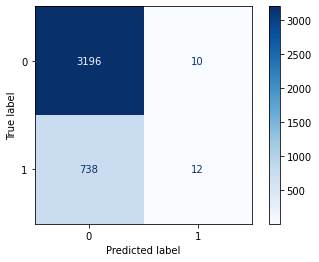

In [102]:
# Confusion Matrix display
plot_confusion_matrix(knn, X_test_knn, y_test_knn, values_format=".4g", cmap="Blues");
tn, fp, fn, tp = confusion_matrix(y_test_knn == 1, y_preds_knn > 0.5).ravel()
tn_knn = tn
fp_knn = fp
fn_knn = fn
tp_knn = tp

In [104]:
# Confusion Matrix display
plot_confusion_matrix(clf_svc, X_test_svc, y_test_svc, values_format=".4g", cmap="Blues");

tn, fp, fn, tp = confusion_matrix(y_test_svc == 1, y_preds_svc > 0.5).ravel()
tn_svc = tn
fp_svc = fp
fn_svc = fn
tp_svc = tp

NameError: name 'clf_svc' is not defined

In [106]:
# Making a copy of the dataset
df_trees = df.copy()

# Dividing the dataset in train (80%) and test (20%)
train_set_dt, test_set_dt = train_test_split(df_trees, test_size = 0.2, random_state = seed)
X_train_dt = train_set_dt.drop(['bad_loan'], axis = 1)
y_train_dt = train_set_dt['bad_loan']
X_test_dt = test_set_dt.drop(['bad_loan'], axis = 1)
y_test_dt = test_set_dt['bad_loan']

clf_tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 10).fit(X_train_dt, y_train_dt)


In [107]:
clf_tree.score(X_test_dt, y_test_dt)

0.782103134479272

In [108]:
important_features = pd.DataFrame(data = clf_tree.feature_importances_, index = X_train_dt.columns, columns = ["value"])
important_features.sort_values(by = "value", ascending = False)

,value
grade,0.214789
dti,0.195808
annual_inc,0.160862
od_ratio,0.151716
revol_util,0.140532
emp_length_num,0.033482
home_ownership_rent,0.018022
term_ 36 months,0.016456
purpose_2,0.013651
purpose_1,0.013289


In [109]:
y_preds_dt = clf_tree.predict_proba(X_test_dt)[:,1]

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


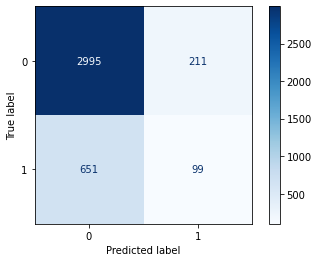

In [111]:
plot_confusion_matrix(clf_tree, X_test_dt, y_test_dt, values_format=".4g", cmap="Blues");

In [112]:
tn, fp, fn, tp = confusion_matrix(y_test_dt == 1, y_preds_dt > 0.5).ravel()
tn_dt = tn
fp_dt = fp
fn_dt = fn
tp_dt = tp

In [115]:
# Making a copy of the dataset
df_rf = df.copy()

# Dividing the dataset in train (80%) and test (20%)
train_set_rf, test_set_rf = train_test_split(df_rf, test_size = 0.2, random_state = seed)
X_train_rf = train_set_rf.drop(['bad_loan'], axis = 1)
y_train_rf = train_set_rf['bad_loan']
X_test_rf = test_set_rf.drop(['bad_loan'], axis = 1)
y_test_rf = test_set_rf['bad_loan']

rf = RandomForestClassifier(random_state = seed, class_weight = None).fit(X_train_rf, y_train_rf)
parameters = {'n_estimators':[10, 100, 300]}
clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train_rf, y_train_rf)

y_preds_rf = clf_rf.predict_proba(X_test_rf)[:,1]


KeyboardInterrupt: 

In [ ]:
plot_confusion_matrix(clf_rf, X_test_rf, y_test_rf, values_format=".4g", cmap="Blues");

tn, fp, fn, tp = confusion_matrix(y_test_rf == 1, y_preds_rf > 0.5).ravel()
tn_rf = tn
fp_rf = fp
fn_rf = fn
tp_rf = tp